### **Objective**

### The goal is try to understand the type of cyclist based on the race metrics (average climb length, average race length), his experience (number of races participated) and his physical attribute (weight)

### Initializzation

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import linkage, dendrogram

In [90]:
cyclists_df = pd.read_csv('./dataset/cyclists_cleaned.csv')

copy = cyclists_df.copy()

Take the records within the percentiles 5-95  of [races_participated], so we exclude extreme numbers, such as 1 or 958. In this way we still have enough records to analized with limit the effect of noise

In [91]:
# Calculate the 25th percentile of races_participated
percentile_1 = copy['races_participated'].quantile(0.05)

# Filter the DataFrame
copy = copy[copy['races_participated'] > percentile_1]

percentile_2 = copy['races_participated'].quantile(0.95)

# Filter the DataFrame
copy = copy[copy['races_participated'] <= percentile_2]

# Display the filtered DataFrame
copy.describe()

,birth_year,weight,height,bmi,races_participated,average_race_length,average_climb_length,average_intensity
count,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000
mean,1976.112078,68.119122,179.464471,21.138305,90.556453,170222.677647,1461.233064,0.009250
std,14.426647,6.034479,6.201190,1.410959,105.972691,27599.494166,875.754133,0.005604
min,1936.000000,52.000000,162.000000,15.700000,2.000000,16650.000000,0.000000,0.000000
25%,1964.000000,64.000000,175.000000,20.200000,11.000000,158439.000000,878.500000,0.005500
50%,1976.000000,68.000000,180.000000,21.100000,43.000000,166372.000000,1612.000000,0.010100
75%,1988.000000,72.000000,184.000000,22.100000,138.000000,176755.000000,2193.500000,0.013900
max,2004.000000,84.000000,197.000000,27.600000,439.000000,294000.000000,4667.000000,0.036500


In [92]:
# Select features for clustering
features = ['weight', 'races_participated', 'average_race_length', 'average_climb_length', 'average_intensity']
feature_data = copy[features]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(feature_data)

# Convert back to a DataFrame for clarity
scaled = pd.DataFrame(scaled, columns=features)

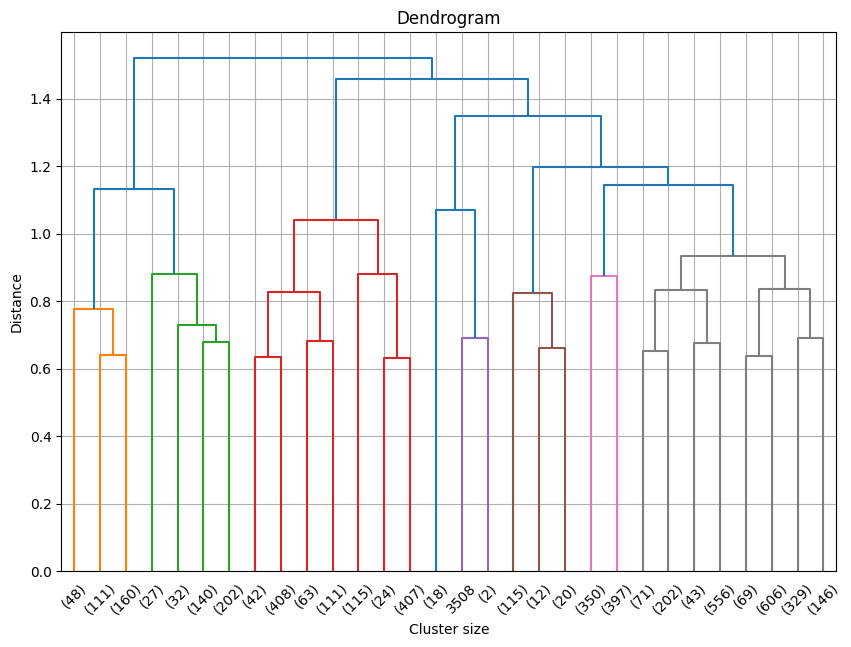

In [93]:
data_dist = pdist(scaled, metric='euclidean')
data_link = linkage(data_dist, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(data_link, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=10)
plt.title('Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

We choose to cut the tree at 1.2 getting 4 clusters

In [94]:
n_clusters = 4
model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = model.fit_predict(scaled)  
feature_data['cluster_labels'] = cluster_labels

C:\Users\zhuji\AppData\Local\Temp\ipykernel_8268\2099280767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data['cluster_labels'] = cluster_labels


cluster_labels
1    1878
0    1266
3     941
2     742
Name: count, dtype: int64
                   weight  races_participated  average_race_length  \
cluster_labels                                                       
0               73.584518           78.770932        169278.970774   
1               64.342918           57.984026        166055.635250   
2               67.711590          292.989218        166057.417790   
3               68.623804           11.795962        183093.093518   

                average_climb_length  average_intensity  
cluster_labels                                           
0                        1519.903633           0.009605  
1                        1969.769436           0.012567  
2                        1833.917790           0.011461  
3                          73.517535           0.000409  


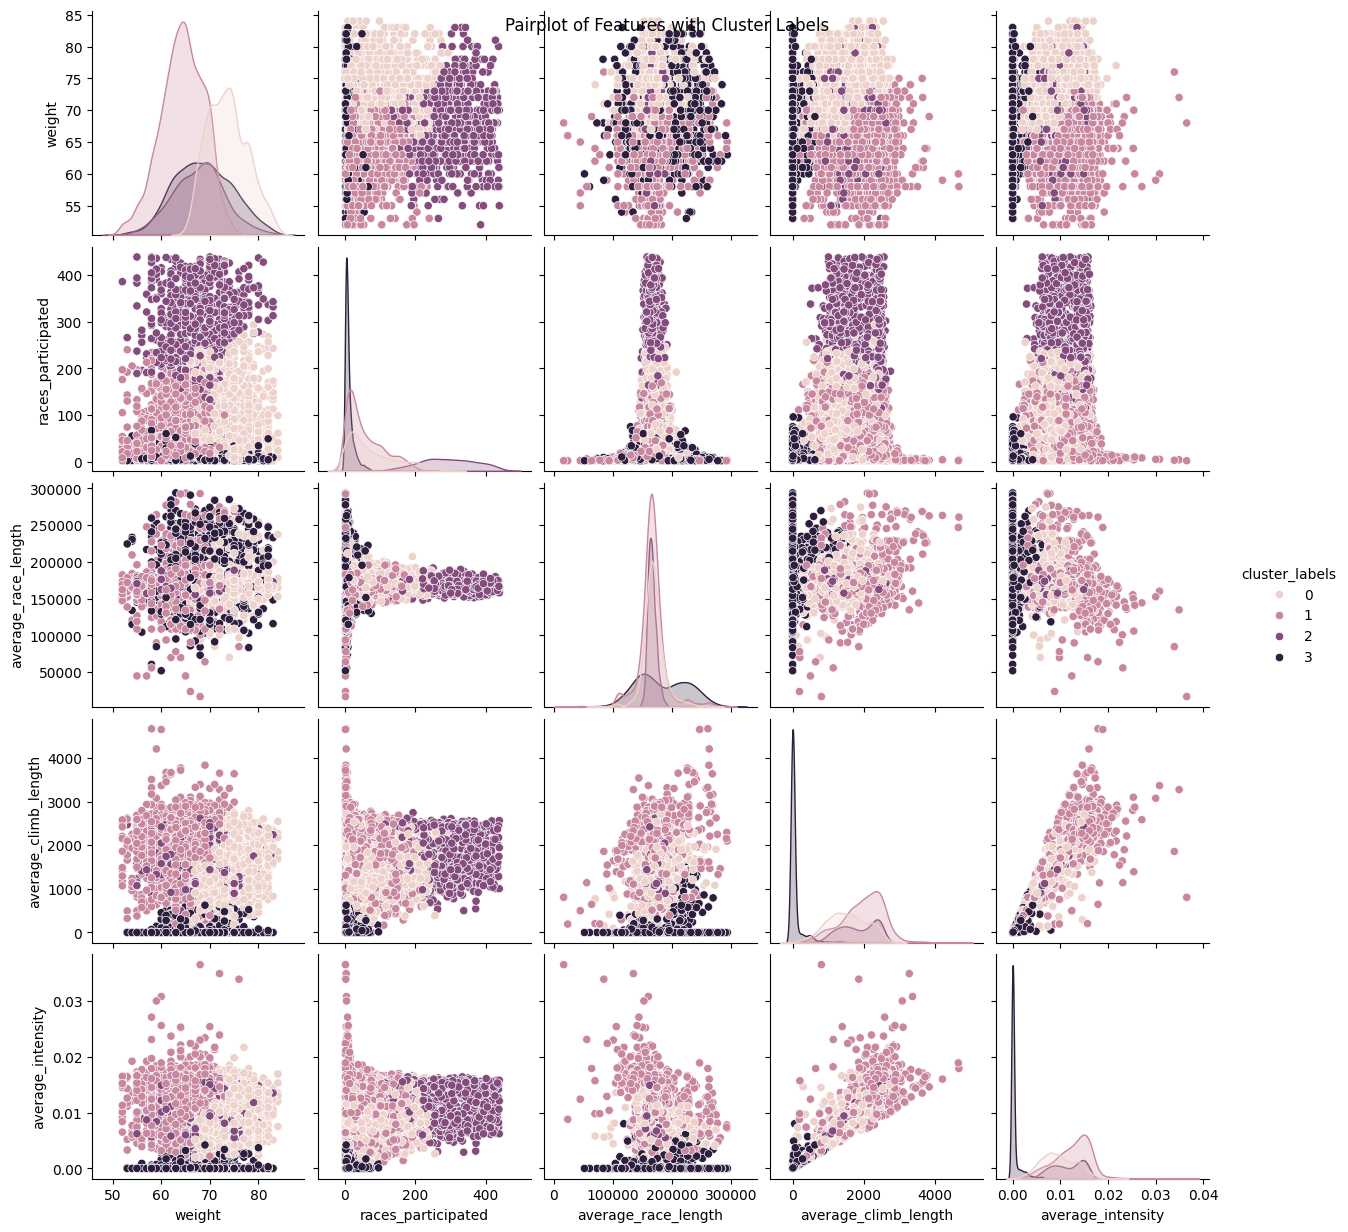

In [95]:
print(feature_data['cluster_labels'].value_counts())

cluster_summary = feature_data.groupby('cluster_labels').mean()
print(cluster_summary)

sns.pairplot(feature_data, hue='cluster_labels')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

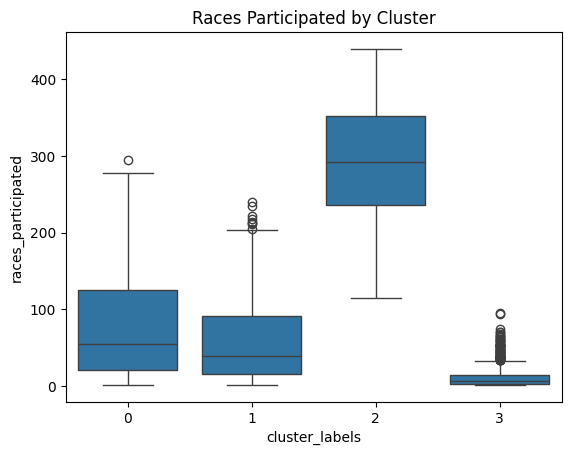

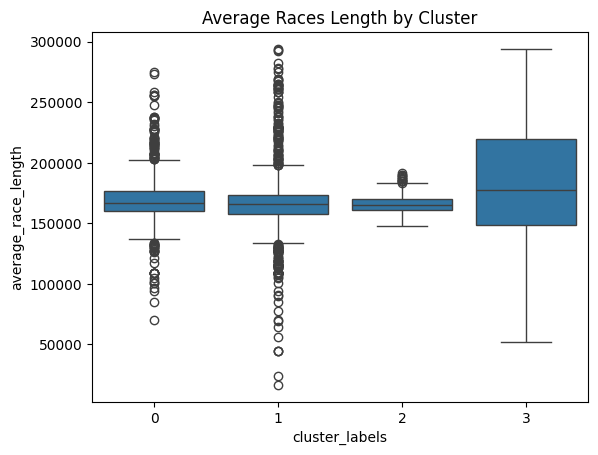

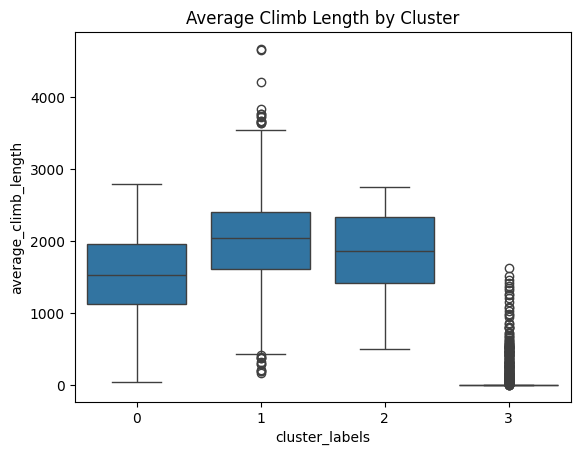

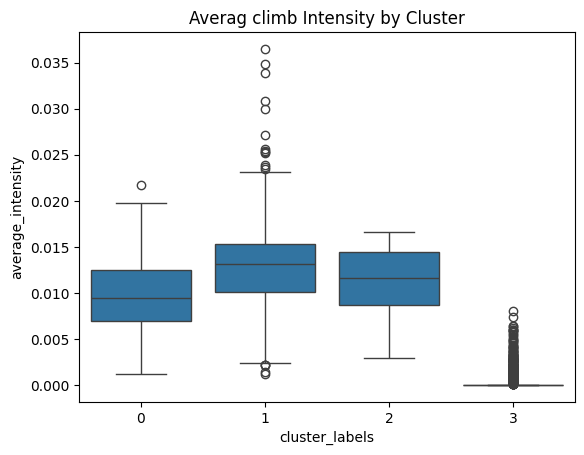

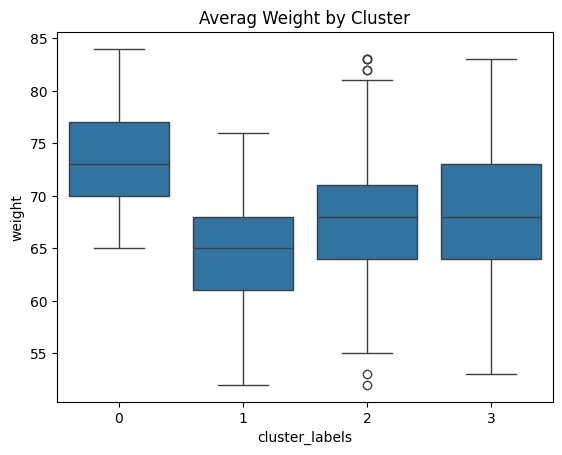

In [99]:
sns.boxplot(x='cluster_labels', y='races_participated', data=feature_data)
plt.title('Races Participated by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='average_race_length', data=feature_data)
plt.title('Average Races Length by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='average_climb_length', data=feature_data)
plt.title('Average Climb Length by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='average_intensity', data=feature_data)
plt.title('Averag climb Intensity by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='weight', data=feature_data)
plt.title('Averag Weight by Cluster')
plt.show()

### Silhouette score

In [97]:
silhouette_avg = silhouette_score(scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.26


### Feature importance

                Feature  Importance
1    races_participated    0.281991
0                weight    0.276684
4     average_intensity    0.227148
3  average_climb_length    0.177572
2   average_race_length    0.036607


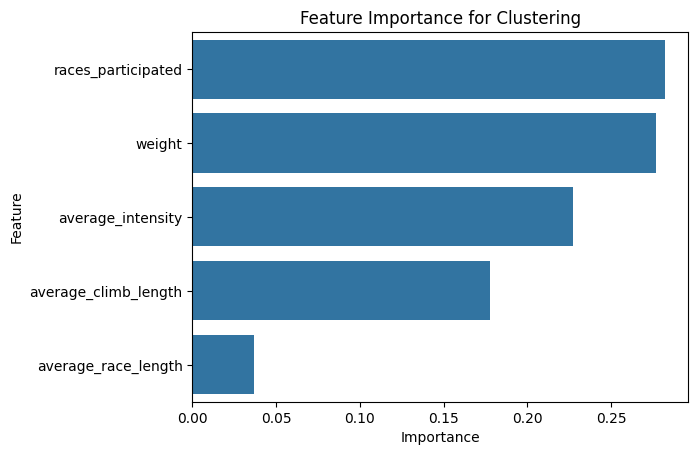

In [98]:
# Add cluster_labels to the copy DataFrame
copy['cluster_labels'] = feature_data['cluster_labels']

X = scaled[features]
y = copy['cluster_labels']

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature Importance
importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)
print(importances)

# Plot Feature Importance
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance for Clustering')
plt.show()

### Observation

0. [average_race_length] has little importance in clustering<br><br>
The result categorizes the records into 4 clusters:<br>
1. cluster **3** has the lowest values on all metrics, including race indicators and experience indicator, we can deduce that this cluster are less experienced cyclists
2. cluster **2** has the highest average race participation, while maintaining high values on other indicators, we can categorized them as experienced cyclists who are agile both on flat and inclined surface
3. cluster **1** has the highest inclined surface indicators and lowest average weight, we believe that they are skilled cyclists in inclined surface
4. cluster **0** represents the average cyslists that are experienced both in flat and inclined surface races but not as mature as cluster 2 